In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% ! important; }<style>"))

/var/folders/jn/wfpqyzfx0t7cprw54pg29r1h0000gn/T/ipykernel_64191/2348643420.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [41]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np 
import ezc3d
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [2]:
#import poi data 
poi_metrics = pd.read_csv("/Volumes/Emilio's Ex/code/Data/OpenBiomechanicsProject/openbiomechanics/baseball_pitching/data/poi/poi_metrics.csv")

poi_metrics_copy = poi_metrics.copy() 
poi_metrics_copy.head()

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,elbow_flexion_fp,elbow_pronation_fp,rotation_hip_shoulder_separation_fp,shoulder_horizontal_abduction_fp,shoulder_abduction_fp,shoulder_external_rotation_fp,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,torso_anterior_tilt_fp,torso_lateral_tilt_fp,torso_rotation_fp,pelvis_anterior_tilt_fp,pelvis_lateral_tilt_fp,pelvis_rotation_fp,max_cog_velo_x,torso_rotation_min,max_pelvis_rotational_velo,glove_shoulder_horizontal_abduction_fp,glove_shoulder_abduction_fp,glove_shoulder_external_rotation_fp,glove_shoulder_abduction_mer,elbow_flexion_mer,torso_anterior_tilt_mer,torso_lateral_tilt_mer,torso_rotation_mer,elbow_varus_moment,shoulder_internal_rotation_moment,torso_anterior_tilt_br,torso_lateral_tilt_br,torso_rotation_br,lead_knee_extension_from_fp_to_br,cog_velo_pkh,stride_length,stride_angle,arm_slot,timing_peak_torso_to_peak_pelvis_rot_velo,max_shoulder_horizontal_abduction,shoulder_transfer_fp_br,shoulder_generation_fp_br,shoulder_absorption_fp_br,elbow_transfer_fp_br,elbow_generation_fp_br,elbow_absorption_fp_br,lead_hip_transfer_fp_br,lead_hip_generation_fp_br,lead_hip_absorption_fp_br,lead_knee_transfer_fp_br,lead_knee_generation_fp_br,lead_knee_absorption_fp_br,rear_hip_transfer_pkh_fp,rear_hip_generation_pkh_fp,rear_hip_absorption_pkh_fp,rear_knee_transfer_pkh_fp,rear_knee_generation_pkh_fp,rear_knee_absorption_pkh_fp,pelvis_lumbar_transfer_fp_br,thorax_distal_transfer_fp_br,rear_grf_x_max,rear_grf_y_max,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,86.3476,13.8688,31.5769,53.7302,88.9089,12.4060,160.4524,449.4070,452.7888,-2.6113,-7.0313,0.3425,8.2744,-1.7844,31.7105,3.3113,-21.1062,609.9531,38.3919,85.9397,-46.6380,45.4970,93.9717,16.9991,22.1885,99.4708,141.1720,135.2726,34.1093,16.9053,111.1709,10.1399,0.4643,0.8374,5.3785,39.7377,0.0223,53.8175,471.6631,72.5180,8.1687,481.4378,7.0827,88.0793,48.2958,11.5949,119.5385,70.8131,74.7670,32.1040,130.8791,173.1504,37.6984,33.8403,111.5650,88.4883,157.7995,479.8318,1019.3193,103.0399,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,88.6095,12.6106,31.2877,55.7340,87.0463,18.5580,300.1992,490.8747,513.3286,-4.2198,-8.5668,3.1764,5.0692,-1.2554,33.9670,3.2385,-23.6528,639.6493,42.5471,85.2882,-47.7522,45.2598,93.6559,14.1951,23.5327,98.4928,144.5483,138.5700,33.9700,18.7871,112.8332,14.8421,0.4367,0.8316,1.1214,42.9766,0.0139,55.9667,468.4177,66.5717,9.3845,474.0084,6.4195,81.1477,65.9816,12.0415,110.9249,89.3801,67.1017,23.9261,125.1987,180.7929,40.8556,28.0193,109.6130,104.7412,170.3120,477.8022,989.5197,109.2064,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,158.8107,121.7674,30.4130,31.7880,47.1102,95.6806,5.7281,-176.7390,318.5102,333.5518,-3.6689,-4.9416,-9.6014,9.5675,-1.9345,22.1156,2.9110,-31.6853,881.1570,46.9422,81.8611,-33.7316,28.7365,83.8787,31.2288,29.1355,129.9182,132.9853,129.8250,45.1741,21.1152,142.5116,26.2749,0.2008,0.8133,7.9460,49.1484,0.0250,49.0236,307.9884,7.2968,54.3387,301.6148,7.7581,24.0842,133.6156,4.6376,106.6119,136.0782,69.9222,26.2777,56.0486,146.2910,62.6569,51.9809,28.8661,25.1778,176.2563,361.8390,681.3699,114.3219,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,155.2244,124.6367,27.9551,27.9139,46.6610,94.4698,1

In [4]:
#remove columns that have no bearing on 'the arm_slot'

columns_to_remove = ['session_pitch', 'session', 'p_throws', 'pitch_type']

poi_metrics_copy = poi_metrics_copy.drop(columns_to_remove, axis=1)

In [31]:

#see what variables associate with 'arm slot'
correlation_matrix = poi_metrics_copy.corr()

target_correlation = correlation_matrix['arm_slot']

#drop the target variable correlation with itself
target_correlation = target_correlation.drop('arm_slot', axis=0)

#sort the values to see top associations
top_associations = target_correlation.sort_values(ascending=False)

#convert to DataFrame for better formatting
top_associations_df = top_associations.reset_index()
top_associations_df.columns = ['Variable', 'Correlation with Arm Slot']

print(top_associations_df.head().to_string(index = False))


               Variable  Correlation with Arm Slot
 torso_lateral_tilt_mer                   0.651968
  torso_lateral_tilt_br                   0.551989
 torso_anterior_tilt_br                   0.522694
torso_anterior_tilt_mer                   0.351911
     torso_rotation_mer                   0.326114


In [34]:
definitions = {
    "torso_lateral_tilt_mer": "Trunk lateral flexion at maximum external rotation (deg)",
    "torso_lateral_tilt_br": "Trunk lateral flexion angle at ball release (deg)",
    "torso_anterior_tilt_br": "Trunk flexion angle at ball release (deg)",
    "torso_anterior_tilt_mer": "Trunk flexion at maximum external rotation (deg)",
    "torso_rotation_mer": "Trunk axial rotation at maximum external rotation (deg)"
}

top_associations_df['Definition'] = top_associations_df['Variable'].map(definitions)
print(top_associations_df.head().to_string(index = False))


               Variable  Correlation with Arm Slot                                               Definition
 torso_lateral_tilt_mer                   0.651968 Trunk lateral flexion at maximum external rotation (deg)
  torso_lateral_tilt_br                   0.551989        Trunk lateral flexion angle at ball release (deg)
 torso_anterior_tilt_br                   0.522694                Trunk flexion angle at ball release (deg)
torso_anterior_tilt_mer                   0.351911         Trunk flexion at maximum external rotation (deg)
     torso_rotation_mer                   0.326114  Trunk axial rotation at maximum external rotation (deg)


Text(0, 0.5, 'Pitch Speed (mph)')

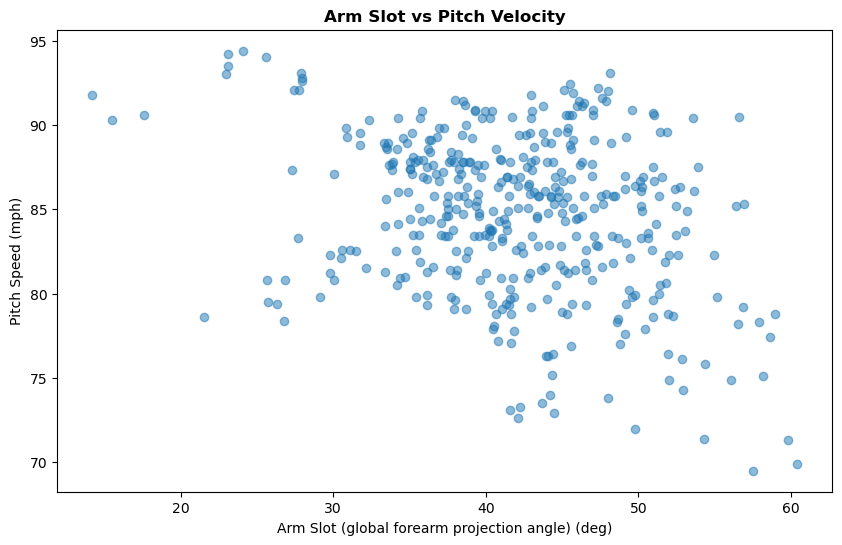

In [37]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(poi_metrics_copy['arm_slot'], poi_metrics_copy['pitch_speed_mph'], alpha=0.5)
plt.title("Arm Slot vs Pitch Velocity", fontweight = 'bold')
plt.xlabel("Arm Slot (global forearm projection angle) (deg)")
plt.ylabel("Pitch Speed (mph)")

## Creating a simple linear regression to see the relationship between arm slot and velocity

In [43]:

X = poi_metrics_copy[['arm_slot']] 
y = poi_metrics_copy['pitch_speed_mph']    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


/Users/EmilioMartinez_1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


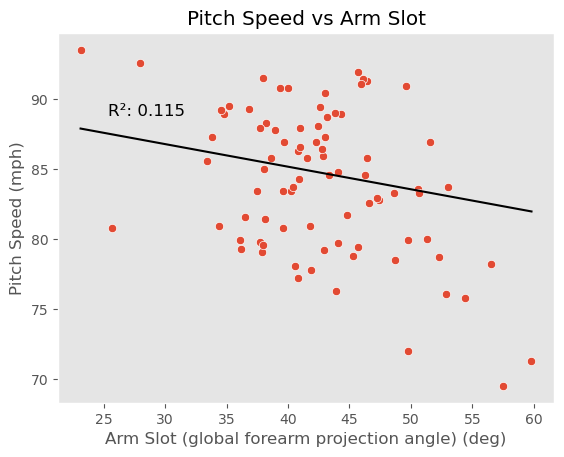

In [51]:
# Set the style to 'ggplot'
plt.style.use('ggplot')

# Scatter plot of the actual data points
sns.scatterplot(x=X_test['arm_slot'], y=y_test)

# Generate regression line values
reg_x = np.linspace(X_test['arm_slot'].min(), X_test['arm_slot'].max(), 100).reshape(-1, 1)
reg_y = model.predict(reg_x)

# Plot the regression line
plt.plot(reg_x, reg_y, color='black')
plt.xlabel('Arm Slot (global forearm projection angle) (deg)')
plt.ylabel('Pitch Speed (mph)')
plt.title('Pitch Speed vs Arm Slot')

# Adding R² value as text with adjusted position
text_x_position = 0.1
text_y_position = 0.81
r2_text = f'R²: {model.score(X_test, y_test):.3f}'
plt.text(text_x_position, text_y_position, r2_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Remove grid lines
plt.grid(False)

# Show the plot
plt.show()

In [67]:

#labels for arm slot angles
buckets = ['Over the Top', 'High 3/4', '3/4', 'Low 3/4', 'Sidearm']

#function to assign buckets to measured arm slots
def assign_bucket(angle):
    return buckets[int(angle // 18)]

#sssign buckets to angles
poi_metrics_copy['angle_bucket'] = pd.Categorical(poi_metrics_copy['arm_slot'].apply(assign_bucket), 
                                                  categories=buckets, 
                                                  ordered=True)

bucket_analysis = poi_metrics_copy.groupby('angle_bucket').agg(
    avg_speed=('pitch_speed_mph', 'mean'),
    pitch_count=('pitch_speed_mph', 'count')
).reset_index()

#create a DataFrame with all buckets
all_buckets_df = pd.DataFrame(buckets, columns=['angle_bucket'])

#merge the all_buckets_df with bucket_analysis, filling NaNs for the table to present them and not skip them
bucket_analysis = pd.merge(all_buckets_df, bucket_analysis, on='angle_bucket', how='left').fillna({'avg_speed': 'NaN', 'pitch_count': 0})

#reset index to make it easier to plot
bucket_analysis = bucket_analysis.reset_index(drop=True)


bucket_analysis


,angle_bucket,avg_speed,pitch_count
0,Over the Top,90.9,3
1,High 3/4,86.249333,75
2,3/4,84.648418,316
3,Low 3/4,77.817647,17
4,Sidearm,NaN,0


In [53]:
avg_speeds.head()

,angle_bucket,pitch_speed_mph
0,3/4,84.648418
1,High 3/4,86.249333
2,Low 3/4,77.817647
3,Over the Top,90.900000


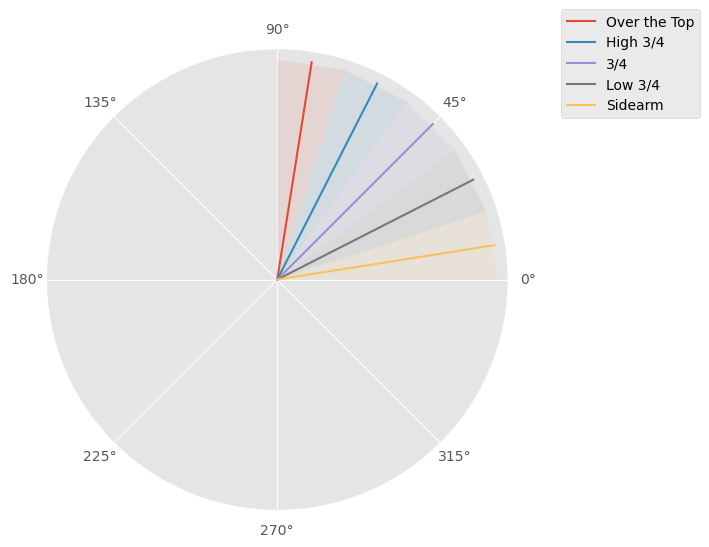

In [60]:
#define the central angles for each bucket (assuming these are the midpoints of each 18-degree segment)
bucket_angles = {
    'Over the Top': 90 - 9,  # Midpoint of 72 to 90 degrees
    'High 3/4': 90 - 9 - 18,
    '3/4': 90 - 9 - 36,
    'Low 3/4': 90 - 9 - 54,
    'Sidearm': 90 - 9 - 72
}

# Set up the plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='polar')

# Draw each bucket
for bucket, angle in bucket_angles.items():
    # Convert angle to radians
    angle_rad = np.deg2rad(angle)

    # Draw a line at the angle
    ax.plot([angle_rad, angle_rad], [0, 1], label=bucket)

    # Shade the area (assuming a 9-degree spread on either side of the central angle)
    ax.fill_between([angle_rad - np.deg2rad(9), angle_rad + np.deg2rad(9)], 0, 1, alpha=0.1)

# Additional plot settings
ax.set_theta_zero_location('E')  # Set 0 degrees at the top
ax.set_theta_direction(1)       # Clockwise
ax.set_rticks([])                # Hide radial ticks
ax.set_yticklabels([])           # Hide radial labels
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))  # Position the legend

# Show the plot
plt.show()


/var/folders/jn/wfpqyzfx0t7cprw54pg29r1h0000gn/T/ipykernel_64306/556876799.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(211, projection='polar')
/var/folders/jn/wfpqyzfx0t7cprw54pg29r1h0000gn/T/ipykernel_64306/556876799.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(212, frame_on=False) # no visible frame


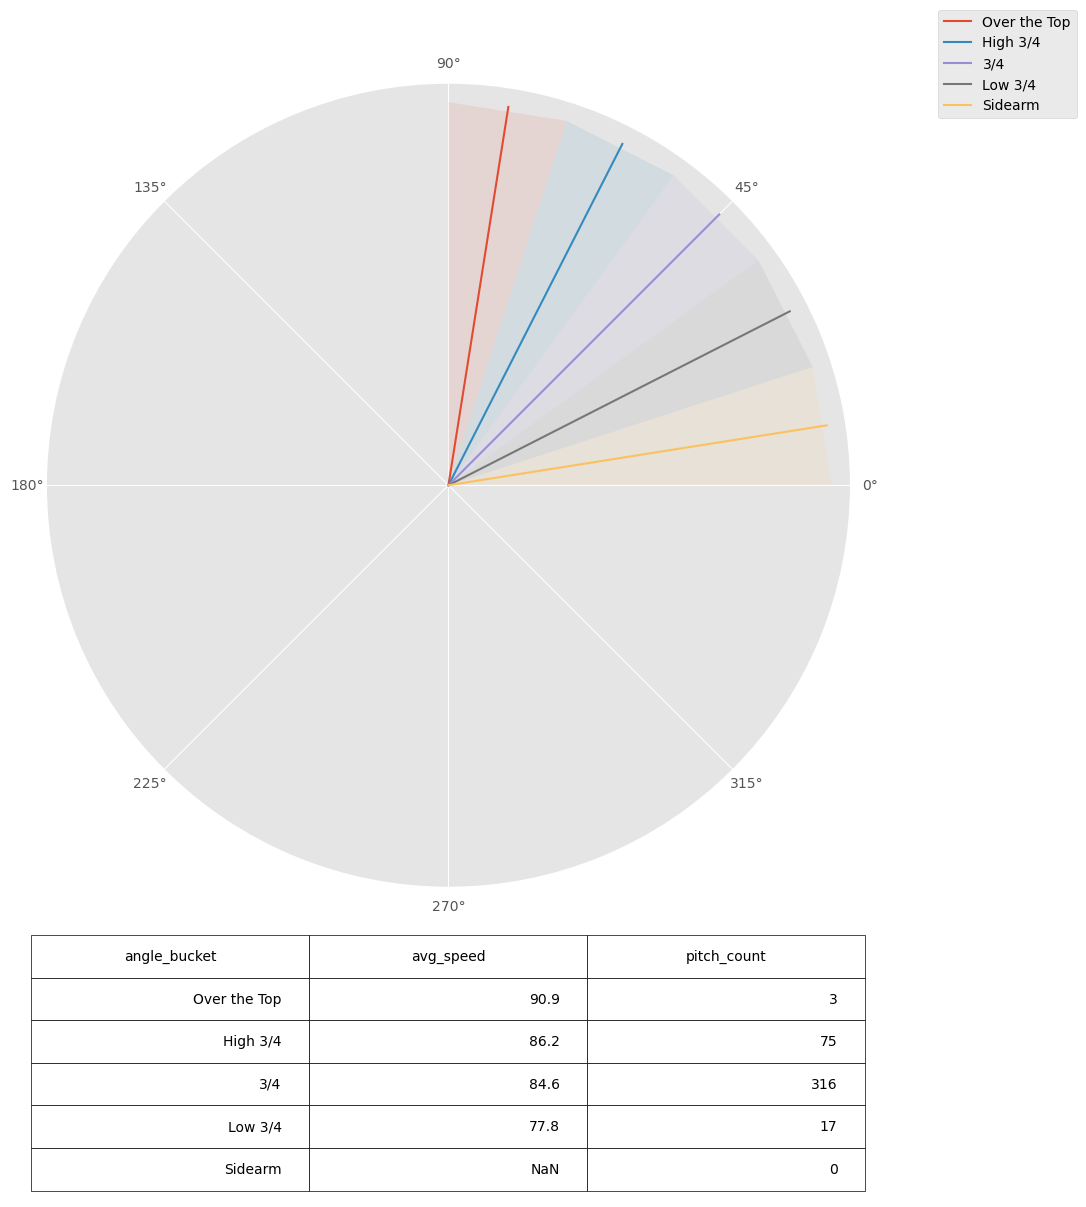

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming poi_metrics_copy and bucket_analysis are defined as per your previous code

bucket_analysis['avg_speed'] = bucket_analysis['avg_speed'].apply(lambda x: f'{x:.1f}' if isinstance(x, float) else x)

# Define bucket angles for polar plot
bucket_angles = {
    'Over the Top': 90 - 9,  # Midpoint of 72 to 90 degrees
    'High 3/4': 90 - 9 - 18,
    '3/4': 90 - 9 - 36,
    'Low 3/4': 90 - 9 - 54,
    'Sidearm': 90 - 9 - 72
}

# Set up the figure
fig, ax = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [3, 1]})

# Polar plot
ax0 = plt.subplot(211, projection='polar')
for bucket, angle in bucket_angles.items():
    angle_rad = np.deg2rad(angle)
    ax0.plot([angle_rad, angle_rad], [0, 1], label=bucket)
    ax0.fill_between([angle_rad - np.deg2rad(9), angle_rad + np.deg2rad(9)], 0, 1, alpha=0.1)

ax0.set_theta_zero_location('E')
ax0.set_theta_direction(1)
ax0.set_rticks([])
ax0.set_yticklabels([])
ax0.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

# Table plot
ax1 = plt.subplot(212, frame_on=False) # no visible frame
ax1.xaxis.set_visible(False)  # hide the x axis
ax1.yaxis.set_visible(False)  # hide the y axis

# Create the table and add cell text
table = ax1.table(cellText=bucket_analysis.values, colLabels=bucket_analysis.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # scale table size

plt.tight_layout()
plt.show()
